In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import joblib
import os
import time

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Для проекта были выбраны датасеты Adult Income Dataset и Employee Attrition Classification Dataset.

# Подготовка данных

## Adult Income Dataset


Данные были извлечены из базы данных Бюро переписи населения США 1994 года. Набор содержит информацию о демографических и профессиональных характеристиках людей с целью прогнозирования, превышает ли их годовой доход $50K.

In [2]:
adult = pd.read_csv('adult.csv')
adult.replace("?", pd.NA, inplace=True)

print(f"Размер данных: {adult.shape[0]} строк, {adult.shape[1]-1} признаков")
print("\nИнформация о данных:")
print(adult.info())
print("\nСтатистика числовых признаков:")
print(adult.describe())
print("\nСтатистика категориальных признаков:")
print(adult.describe(include=['object']))
print("\nПримеры значений (первые 5 строк):")
print(adult.head())

Размер данных: 32561 строк, 14 признаков

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

Статистика числовых приз

In [3]:
# Проверяем пропуски
print("\nОставшиеся пропуски:")
print(adult.isnull().sum())


Оставшиеся пропуски:
age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64


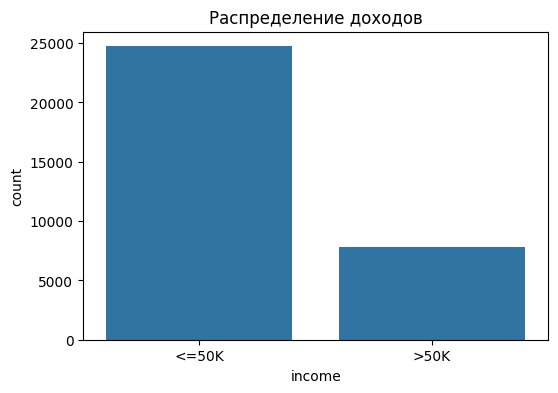

In [4]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='income', data=adult)
plt.title('Распределение доходов')
plt.show()

Особенности:

32,561 записей

14 признаков (6 числовых, 8 категориальных)

Целевая переменная: income (бинарная - <=50K или >50K). Присутствует дисбаланс классов.

Имеются пропущенные значения в workclass, occupation, native_country

Финальный вес (fnlwgt) сильно варьируется от 12,285 до 1,484,705 и имеет большой разброс (std = 105,550), что указывает на значительную вариативность

У 75 % респондентов нет капитального дохода/убытка. Максимальный доход: 99,999 (возможно аномалия), максимальный убыток: 4,356

Часы работы (hours.per.week): среднее: ~40.4 часа, медиана: 40 часов (стандартная рабочая неделя). Вероятно, есть аномалии (мин. 1 час, макс. 99 часов).

Средний возраст ~38.6 лет, медиана: 37 лет,

Относительно симметричное распределение по часам работы и возрасту (медиана близка к среднему)

### Анализ и обработка пропусков

In [5]:
# Анализ распределения в признаках с пропусками
print("\nРаспределение workclass:")
print(adult['workclass'].value_counts(dropna=False, normalize=True))

print("\nРаспределение occupation:")
print(adult['occupation'].value_counts(dropna=False, normalize=True))

print("\nРаспределение native.country:")
print(adult['native.country'].value_counts(dropna=False, normalize=True))


Распределение workclass:
workclass
Private             0.697030
Self-emp-not-inc    0.078038
Local-gov           0.064279
<NA>                0.056386
State-gov           0.039864
Self-emp-inc        0.034274
Federal-gov         0.029483
Without-pay         0.000430
Never-worked        0.000215
Name: proportion, dtype: float64

Распределение occupation:
occupation
Prof-specialty       0.127146
Craft-repair         0.125887
Exec-managerial      0.124873
Adm-clerical         0.115783
Sales                0.112097
Other-service        0.101195
Machine-op-inspct    0.061485
<NA>                 0.056601
Transport-moving     0.049046
Handlers-cleaners    0.042075
Farming-fishing      0.030527
Tech-support         0.028500
Protective-serv      0.019932
Priv-house-serv      0.004576
Armed-Forces         0.000276
Name: proportion, dtype: float64

Распределение native.country:
native.country
United-States                 0.895857
Mexico                        0.019748
<NA>                     

В категориях workclass и occupation пропуски составляют значимую часть (около 5 %), поэтому заполнение модой может исказить данные. Также нельзя ограничиться полным удалением этих строк.

В workclass выделим пропуски в отдельную категорию, occupation_by_workclass заполним изходя из workclass.

В категории стран преобладает США, при этом сам процент пропуков невелик, поэтому заполнение пропусков модой не отразится значимым образом на распределении.

In [6]:
adult['workclass'] = adult['workclass'].fillna('Unknown')

# умное заполнение на основе workclass
occupation_by_workclass = adult.groupby('workclass')['occupation'].agg(pd.Series.mode)
adult['occupation'] = adult.apply(
     lambda row: occupation_by_workclass[row['workclass']] if pd.isna(row['occupation']) else row['occupation'],
     axis=1
 )
adult['native.country'].fillna('United-States', inplace=True)

<ipython-input-6-3969896996>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adult['native.country'].fillna('United-States', inplace=True)


In [7]:
# Проверяем оставшиеся пропуски
print("\nОставшиеся пропуски:")
print(adult.isnull().sum())


Оставшиеся пропуски:
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


### Обработка аномалий


Анализ hours.per.week:
Минимальное значение: 1
Максимальное значение: 99


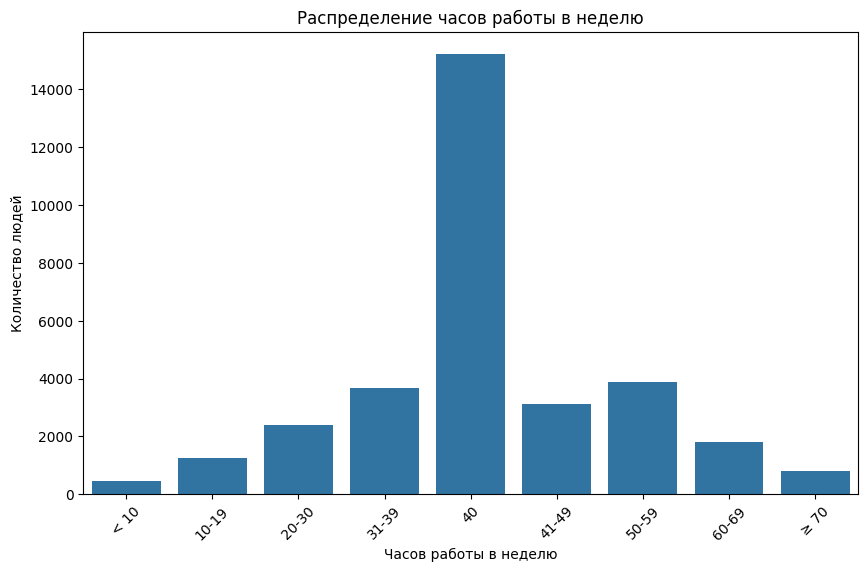

In [8]:
# Анализ аномальных значений в hours.per.week
print("\nАнализ hours.per.week:")
print("Минимальное значение:", adult['hours.per.week'].min())
print("Максимальное значение:", adult['hours.per.week'].max())

# Визуализация распределения
bins = [0, 10, 20, 30, 40, 41, 50, 60, 70, 100]
labels = ['< 10', '10-19', '20-30', '31-39', '40', '41-49', '50-59', '60-69', '≥ 70']
adult['hours_category'] = pd.cut(adult['hours.per.week'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=adult, x='hours_category', order=labels)
plt.title('Распределение часов работы в неделю')
plt.xlabel('Часов работы в неделю')
plt.ylabel('Количество людей')
plt.xticks(rotation=45)
plt.show()

Вероятно, аномальные значения могут быть вызваны аномальными рабочими графиками (врачи, вахтеры, предприниматели или студенты, пенсионеры и стажеры в случае короткой рабочей недели). Основная масса респондентов работает в стандартном 40-часвом формате. Даже если высокие/низкие значения это ошибка в данных, на общую статистику это не влияет в существенной мере.


Анализ возраста:
Минимальное значение: 17
Максимальное значение: 90


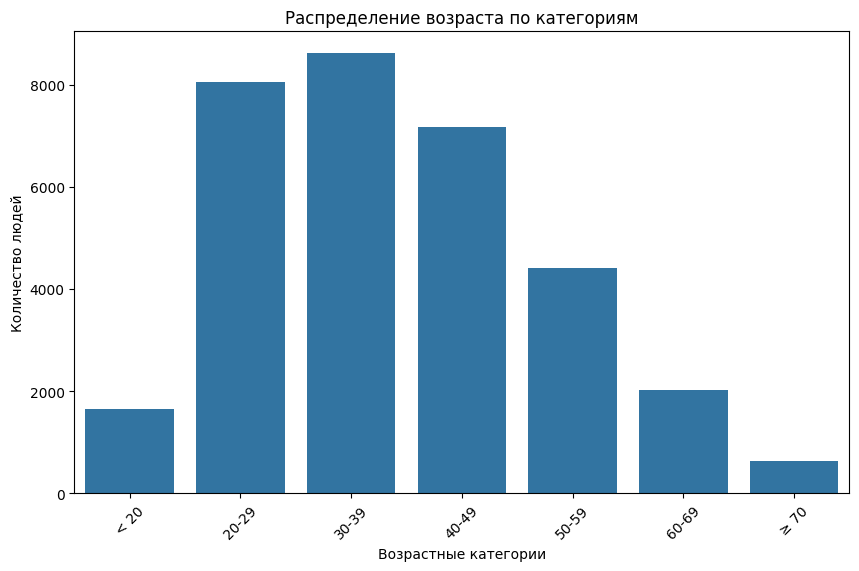

In [9]:
print("\nАнализ возраста:")
print("Минимальное значение:", adult['age'].min())
print("Максимальное значение:", adult['age'].max())
# Визуализация
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['< 20', '20-29', '30-39', '40-49', '50-59', '60-69', '≥ 70']
adult['age_category'] = pd.cut(adult['age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=adult, x='age_category', order=labels)
plt.title('Распределение возраста по категориям')
plt.xlabel('Возрастные категории')
plt.ylabel('Количество людей')
plt.xticks(rotation=45)
plt.show()

In [10]:
overworked = adult[adult['hours.per.week'] >= 70]

# Основные статистики
print(f"Всего людей, работающих 70+ часов: {len(overworked)}")
print(f"Доля от общего числа: {len(overworked)/len(adult)*100:.2f}%")
print("\nСредние показатели:")
print(overworked[['age', 'hours.per.week', 'capital.gain', 'capital.loss', 'education.num']].mean())

Всего людей, работающих 70+ часов: 789
Доля от общего числа: 2.42%

Средние показатели:
age                 40.794677
hours.per.week      78.396705
capital.gain      2715.373891
capital.loss       125.552598
education.num       10.448669
dtype: float64



Топ-10 профессий (доля в %):
occupation
Exec-managerial      15.969582
Prof-specialty       15.589354
Farming-fishing      15.209125
Transport-moving     10.646388
Sales                 9.125475
Craft-repair          8.745247
Other-service         7.351077
Protective-serv       4.182510
Unknown               4.055767
Machine-op-inspct     2.534854
Name: proportion, dtype: float64


<ipython-input-11-2052383896>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overworked['occupation'] = overworked['occupation'].astype(str).replace('\[\]', 'Unknown', regex=True)


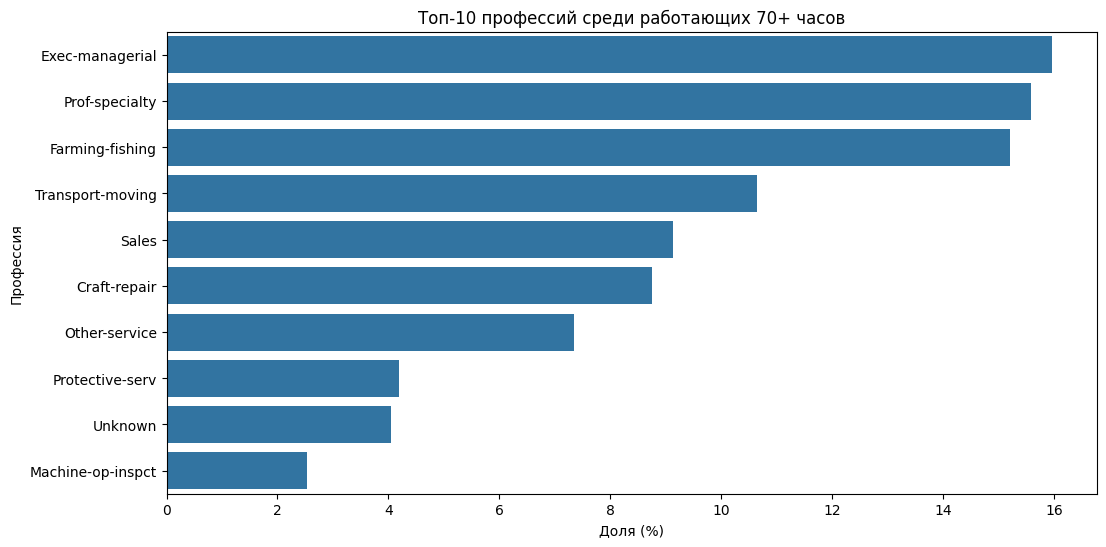

In [11]:
overworked['occupation'] = overworked['occupation'].astype(str).replace('\[\]', 'Unknown', regex=True)

# Топ-10 профессий
top_occupations = (overworked['occupation'].value_counts(normalize=True) * 100).head(10)

print("\nТоп-10 профессий (доля в %):")
print(top_occupations)

# Визуализация с проверкой данных
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_occupations.values,
    y=top_occupations.index,
    order=top_occupations.index  # Явное указание порядка
)
plt.title('Топ-10 профессий среди работающих 70+ часов')
plt.xlabel('Доля (%)')
plt.ylabel('Профессия')
plt.show()

Большинство перерабатывающих людей это люди на руководящих должностях, люди со своим бизнесом (буквально живущие работой) и водители, поэтому изначальное предположение оказалось верным и 70+ часов работы в неделю это не аномалия.

### Корреляция признаков

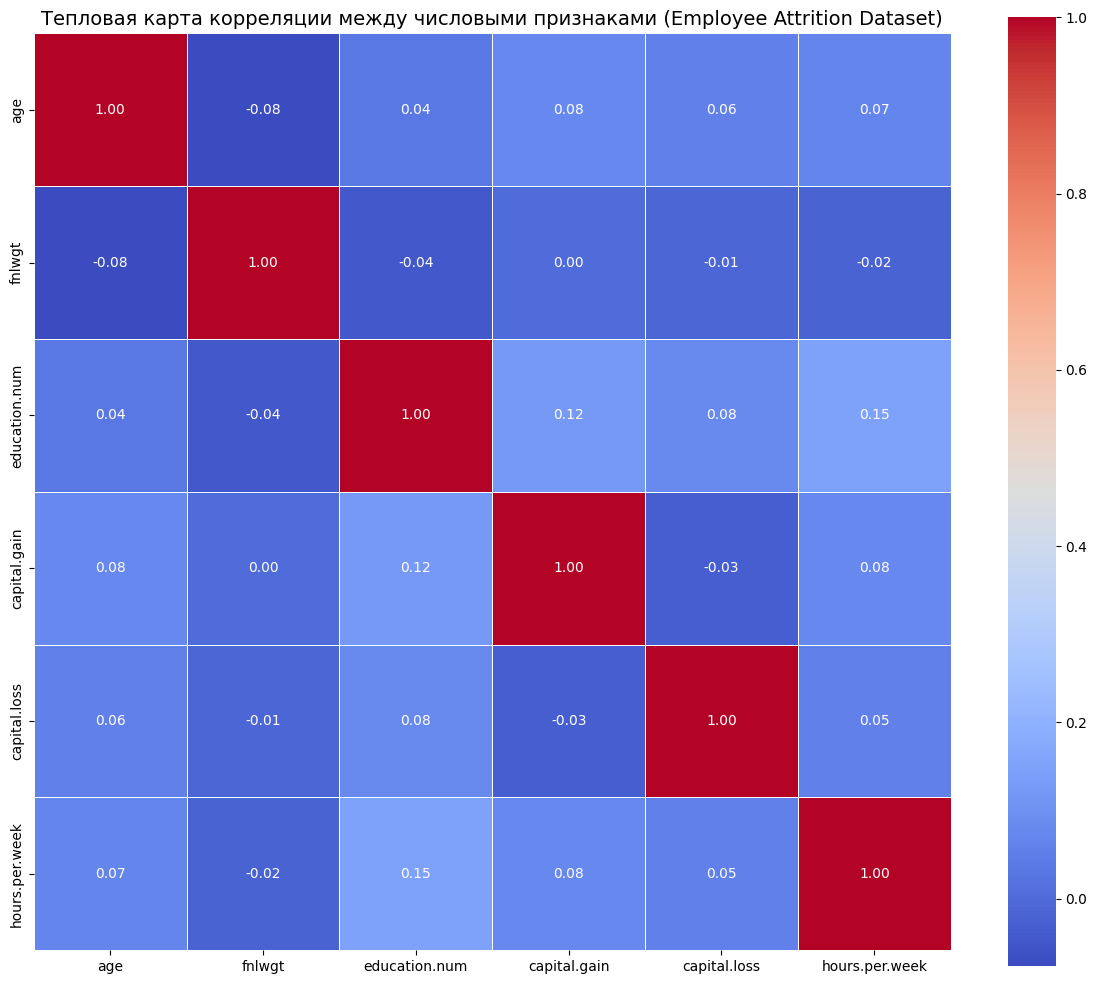

In [42]:
adult_num_df = adult.select_dtypes(include=['int64', 'float64'])

# Корреляционная матрица
corr_matrix = adult_num_df.corr()

# Тепловая карта
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Тепловая карта корреляции между числовыми признаками (Employee Attrition Dataset)", fontsize=14)
plt.tight_layout()
plt.show()

Ожидаемо, никакой корреляции между признаками нет.

### Разделение данных

In [12]:
adult['occupation'] = adult['occupation'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else x)

In [13]:
# Преобразование категориальных признаков в числовые (one-hot encoding)
adult_encoded = pd.get_dummies(adult, drop_first=True)

# Разделение данных на признаки (X) и метки (y)
X_1 = adult_encoded.drop('income_>50K', axis=1)
y_1 = adult_encoded['income_>50K']

# Разделение данных на тренировочные и тестовые выборки
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=112)

# Вывод размеров выборок
print(f"Размер тренировочной выборки: {X_train_1.shape[0]} строк")
print(f"Размер тестовой выборки: {X_test_1.shape[0]} строк")

Размер тренировочной выборки: 26048 строк
Размер тестовой выборки: 6513 строк


In [14]:
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

## Employee Attrition Dataset

Синтетический датасет для анализа и прогнозирования текучести кадров. Содержит подробную информацию о различных аспектах профиля сотрудника.



In [15]:
# Загрузка train и test данных
train_attr = pd.read_csv('train.csv')
test_attr = pd.read_csv('test.csv')
attr = pd.concat([train_attr, test_attr])

#adult.replace("?", pd.NA, inplace=True)
print(f"Размер тренировочных данных: {train_attr.shape[0]} строк, {train_attr.shape[1]-1} признаков")
print(f"Размер тестовых данных: {test_attr.shape[0]} строк, {test_attr.shape[1]-1} признаков")
print(f"Соотношение размера тренировочных данных к общему: {train_attr.shape[0] / attr.shape[0]:.2f}")

print(f"Общий размер данных: {attr.shape[0]} строк, {attr.shape[1]-1} признаков")
print("\nИнформация о данных:")
print(attr.info())
print("\nСтатистика числовых признаков:")
print(attr.describe())
print("\nСтатистика категориальных признаков:")
print(attr.describe(include=['object']))
print("\nПримеры значений (первые 5 строк):")
print(attr.head())

Размер тренировочных данных: 59598 строк, 23 признаков
Размер тестовых данных: 14900 строк, 23 признаков
Соотношение размера тренировочных данных к общему: 0.80
Общий размер данных: 74498 строк, 23 признаков

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 74498 entries, 0 to 14899
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Employee ID               74498 non-null  int64 
 1   Age                       74498 non-null  int64 
 2   Gender                    74498 non-null  object
 3   Years at Company          74498 non-null  int64 
 4   Job Role                  74498 non-null  object
 5   Monthly Income            74498 non-null  int64 
 6   Work-Life Balance         74498 non-null  object
 7   Job Satisfaction          74498 non-null  object
 8   Performance Rating        74498 non-null  object
 9   Number of Promotions      74498 non-null  int64 
 10  Overtime     

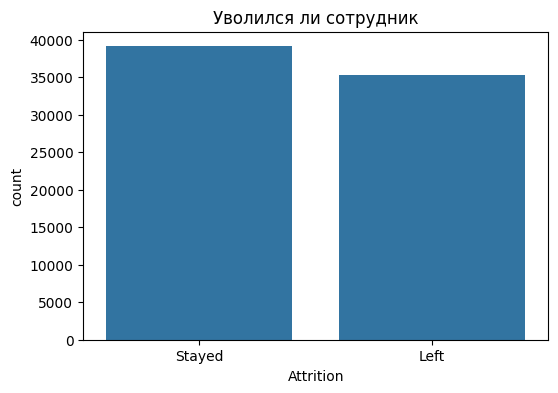

In [16]:
# Визуализация распределения целевой переменной
plt.figure(figsize=(6, 4))
sns.countplot(x='Attrition', data=attr)
plt.title('Уволился ли сотрудник')
plt.show()

Особенности:

Изначально разделен на train/test

74,498 записей (train: 52,149, test: 22,349)

23 признака (8 числовых и 15 категориальных)

Целевая переменная: Attrition (бинарная - 0/1), показывает уволился ли сотрудник. Дисбаланс классов отсутствует.

Нет пропущенных значений


Анализ доходов:
Минимальное значение: 18
Максимальное значение: 59


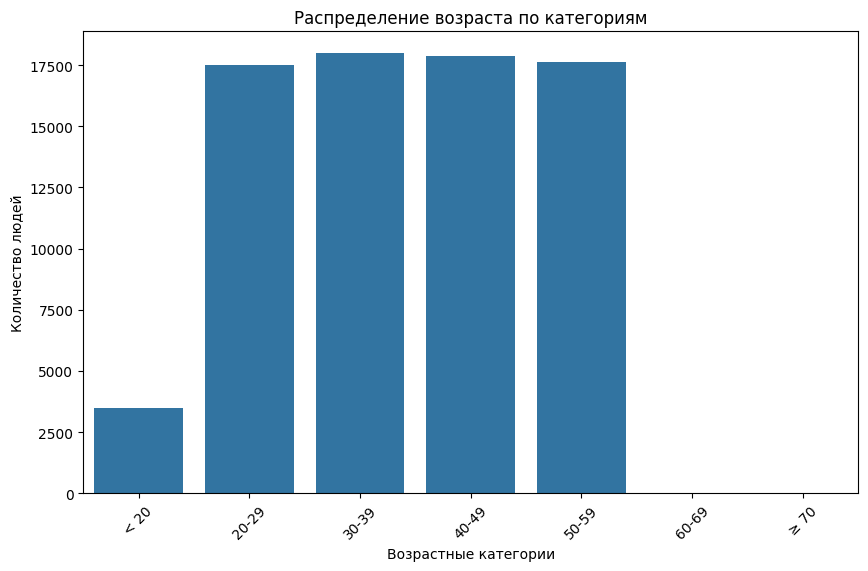

In [17]:
print("\nАнализ доходов:")
print("Минимальное значение:", attr['Age'].min())
print("Максимальное значение:", attr['Age'].max())

# Визуализация
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['< 20', '20-29', '30-39', '40-49', '50-59', '60-69', '≥ 70']
attr['age_category'] = pd.cut(attr['Age'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=attr, x='age_category', order=labels)
plt.title('Распределение возраста по категориям')
plt.xlabel('Возрастные категории')
plt.ylabel('Количество людей')
plt.xticks(rotation=45)
plt.show()

На гистрограмме можо увидеть одно из следствий синтетической природы данных -- равомерное распределение по возрасту. Более естественным моделированием было бы генерирование нормального распределения.


Анализ возраста:
Минимальное значение: 1226
Максимальное значение: 16149


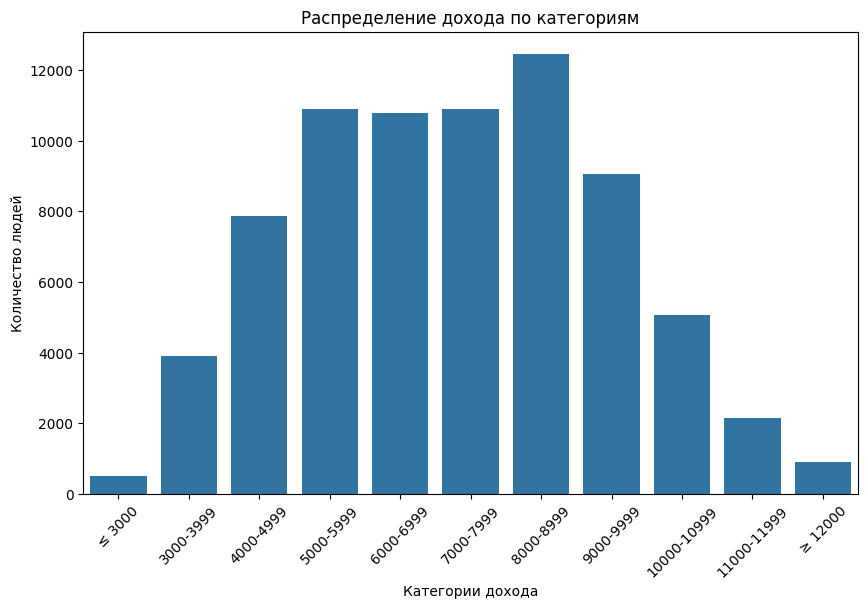

In [18]:
print("\nАнализ возраста:")
print("Минимальное значение:", attr['Monthly Income'].min())
print("Максимальное значение:", attr['Monthly Income'].max())

# Визуализация
bins = [0, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 17000]
labels = ['≤ 3000', '3000-3999', '4000-4999', '5000-5999', '6000-6999', '7000-7999', '8000-8999', '9000-9999', '10000-10999', '11000-11999', '≥ 12000']
attr['income_category'] = pd.cut(attr['Monthly Income'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(data=attr, x='income_category', order=labels)
plt.title('Распределение дохода по категориям')
plt.xlabel('Категории дохода')
plt.ylabel('Количество людей')
plt.xticks(rotation=45)
plt.show()

Распределение доходов респондентов более равномерно, однако, тоже остается следствием синтетической природы данных, поскольку реальные доходы распределены неравномерно, а скорее "поклассово".

### Корреляция признаков

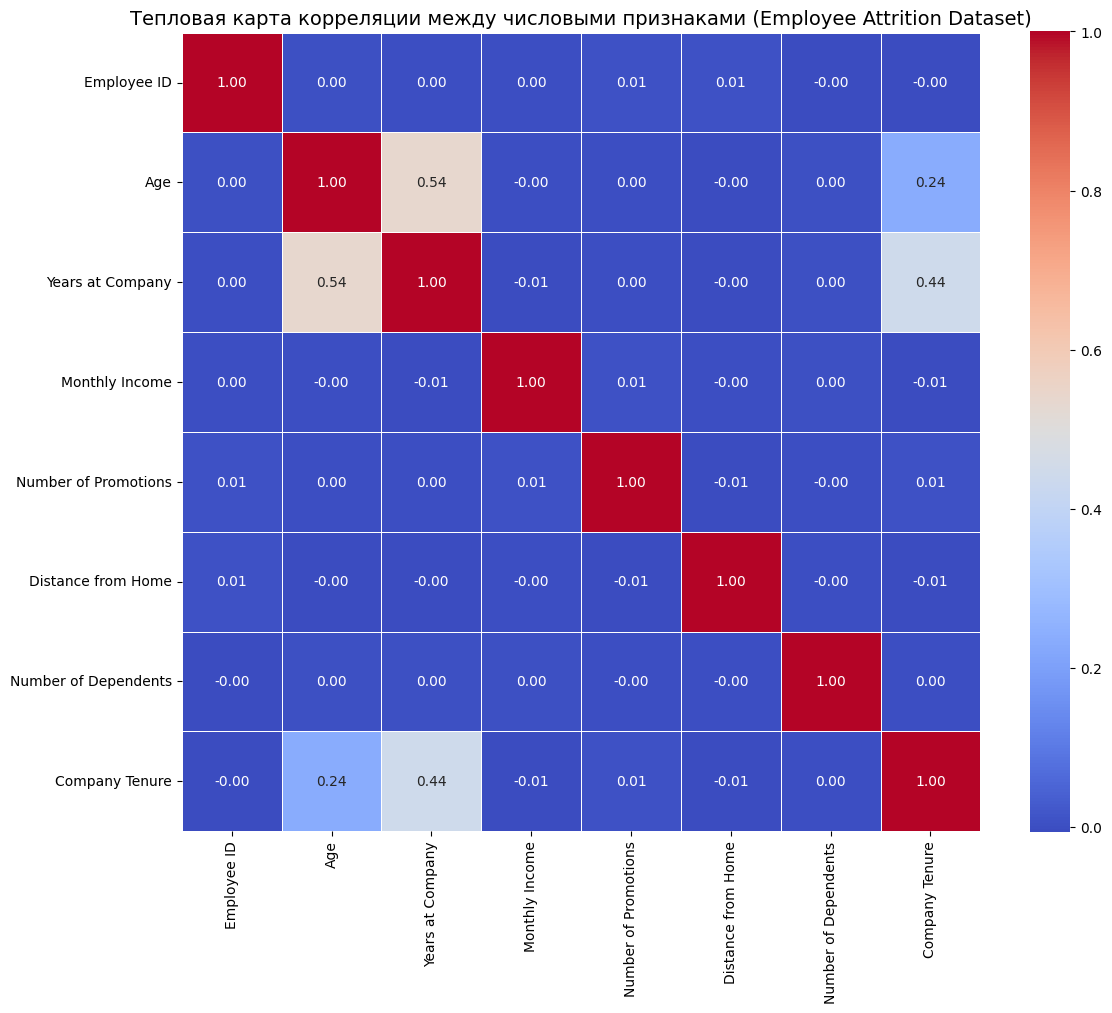

In [43]:
attr_num_df = attr.select_dtypes(include=['int64', 'float64'])

# Корреляционная матрица
corr_matrix = attr_num_df.corr()

# Тепловая карта
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Тепловая карта корреляции между числовыми признаками (Employee Attrition Dataset)", fontsize=14)
plt.tight_layout()
plt.show()

Имеется корреляция между стажем, стажем в компании и возрастом. Другой корреляции нет.

### Разделение данных

In [19]:
attr_encoded = pd.get_dummies(attr, drop_first=True)

train_encoded = attr_encoded.iloc[:len(train_attr)].copy()
test_encoded = attr_encoded.iloc[len(train_attr):].copy()

X_train_2 = train_encoded.drop('Attrition_Stayed', axis=1)
y_train_2 = train_encoded['Attrition_Stayed']

X_test_2 = test_encoded.drop('Attrition_Stayed', axis=1)
y_test_2 = test_encoded['Attrition_Stayed']

print(f"Размер тренировочной выборки: {X_train_2.shape[0]} строк")
print(f"Размер тестовой выборки: {X_test_2.shape[0]} строк")

Размер тренировочной выборки: 59598 строк
Размер тестовой выборки: 14900 строк


In [20]:
scaler = StandardScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

# Обучение и оценка моделей

Сравним модели по соответствующим метрикам

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=5000),
    "SVM": SVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

def evaluate_models(X_train, y_train, X_test, y_test, dataset_name):
    print(f"\n{'='*30}\n Результаты: {dataset_name}\n{'='*30}")
    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        target_class = 'True'
        metrics_1 = report[target_class]
        results.append({
            "Model": name,
            "Accuracy": report.get("accuracy", 0.0),
            "Precision": metrics_1["precision"],
            "Recall": metrics_1["recall"],
            "F1-Score": metrics_1["f1-score"]
        })
        print(f'confusion_matrix "Model": {name}')
        print(confusion_matrix(y_test, y_pred))
    df = pd.DataFrame(results).sort_values(by="F1-Score", ascending=False).round(3)
    print(df.to_string(index=False))

evaluate_models(X_train_1, y_train_1, X_test_1, y_test_1, "Adult Income Dataset (not scaled)")
evaluate_models(X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1, "Adult Income Dataset")

evaluate_models(X_train_2, y_train_2, X_test_2, y_test_2, "Employee Attrition Dataset(not scaled)")
evaluate_models(X_train_scaled_2, y_train_2, X_test_scaled_2, y_test_2, "Employee Attrition Dataset")


 Результаты: Adult Income Dataset (not scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


confusion_matrix "Model": Logistic Regression
[[3898 1030]
 [ 236 1349]]
confusion_matrix "Model": SVM
[[4868   60]
 [1280  305]]
confusion_matrix "Model": Random Forest
[[4565  363]
 [ 601  984]]
confusion_matrix "Model": Gradient Boosting
[[4651  277]
 [ 648  937]]
confusion_matrix "Model": Naive Bayes
[[4680  248]
 [1092  493]]
confusion_matrix "Model": KNN
[[4528  400]
 [1079  506]]
              Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression     0.806      0.567   0.851     0.681
      Random Forest     0.852      0.731   0.621     0.671
  Gradient Boosting     0.858      0.772   0.591     0.670
        Naive Bayes     0.794      0.665   0.311     0.424
                KNN     0.773      0.558   0.319     0.406
                SVM     0.794      0.836   0.192     0.313

 Результаты: Adult Income Dataset
confusion_matrix "Model": Logistic Regression
[[3923 1005]
 [ 236 1349]]
confusion_matrix "Model": SVM
[[3880 1048]
 [ 251 1334]]
confusion_matrix "Model": Random

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


confusion_matrix "Model": Logistic Regression
[[5292 1740]
 [1990 5878]]
confusion_matrix "Model": SVM
[[3272 3760]
 [3620 4248]]
confusion_matrix "Model": Random Forest
[[5148 1884]
 [1877 5991]]
confusion_matrix "Model": Gradient Boosting
[[5192 1840]
 [1768 6100]]
confusion_matrix "Model": Naive Bayes
[[4904 2128]
 [2174 5694]]
confusion_matrix "Model": KNN
[[3246 3786]
 [3602 4266]]
              Model  Accuracy  Precision  Recall  F1-Score
  Gradient Boosting     0.758      0.768   0.775     0.772
      Random Forest     0.748      0.761   0.761     0.761
Logistic Regression     0.750      0.772   0.747     0.759
        Naive Bayes     0.711      0.728   0.724     0.726
                KNN     0.504      0.530   0.542     0.536
                SVM     0.505      0.530   0.540     0.535

 Результаты: Employee Attrition Dataset
confusion_matrix "Model": Logistic Regression
[[5322 1710]
 [1952 5916]]
confusion_matrix "Model": SVM
[[5287 1745]
 [2046 5822]]
confusion_matrix "Model": 

---Adult Income Dataset---

Нормализация данных помогает,
Logistic Regression и SVM существенно выигрывают при масштабировании признаков.

У логистической регрессии увеличилась точность с 0.806 до 0.809, F1-score с 0.681 до 0.685.

SVM показал резкий прирост recall с 0.192 до 0.842, что говорит о важности нормализации для этой модели.

Лучшие по точности: Gradient Boosting и Random Forest.

Лучшие по балансу Precision/Recall: Logistic Regression, особенно с нормализацией.

Наихудший результат: Naive Bayes (без нормализации — катастрофически высокое смещение).

Нормализация необходима для моделей, чувствительных к масштабу (SVM, KNN, Logistic Regression).

---Employee Attrition Dataset---

Почти не чувствителен к масштабированию. Разница между scaled и not scaled минимальна у всех моделей, кроме SVM и KNN.

SVM и KNN: ненормализованные признаки дают очень низкую точность (~0.50), но нормализация выводит SVM на уровень ≈ 0.75.

Лучшие модели: Gradient Boosting, Logistic Regression и Random Forest.

Naive Bayes работает приемлемо, но хуже ансамблевых моделей.

# Уменьшение размерности

PCA (Principal Component Analysis)

-- Показывает глобальную структуру данных

-- Подходит для выявления основных направлений вариации данных

t-SNE (t-Distributed Stochastic Neighbor Embedding)

-- Акцентирует локальные кластеры и группировки

-- Сохраняет структуру соседства точек

-- Подходит для обнаружения скрытых паттернов

LDA (Linear Discriminant Analysis)

-- Специально оптимизирована для максимизации разделения классов

-- Показывает, насколько хорошо признаки разделяют целевые классы

-- Для бинарной классификации будет только одна компонента (гистограмма)

-- Если классы хорошо разделены - LDA даст четкую визуализацию

In [24]:
def plot_dim_reduction(X, y, method, title):
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "t-SNE":
        reducer = TSNE(n_components=2, random_state=42)
    elif method == "LDA":
        reducer = LDA(n_components=1)

    X_reduced = reducer.fit_transform(X, y) if method == "LDA" else reducer.fit_transform(X)

    plt.figure(figsize=(8,6))
    if X_reduced.shape[1] == 1:
        plt.scatter(X_reduced[:, 0], np.zeros_like(X_reduced[:, 0]), c=y, cmap='coolwarm', edgecolor='k')
    else:
        plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='coolwarm', edgecolor='k')
    plt.title(f"{title} using {method}")
    plt.xlabel('Component 1')
    if X_reduced.shape[1] > 1:
        plt.ylabel('Component 2')
    plt.show()

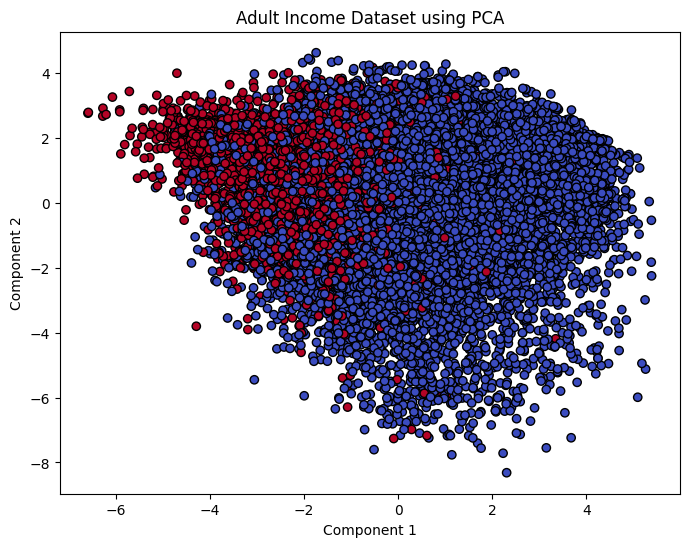

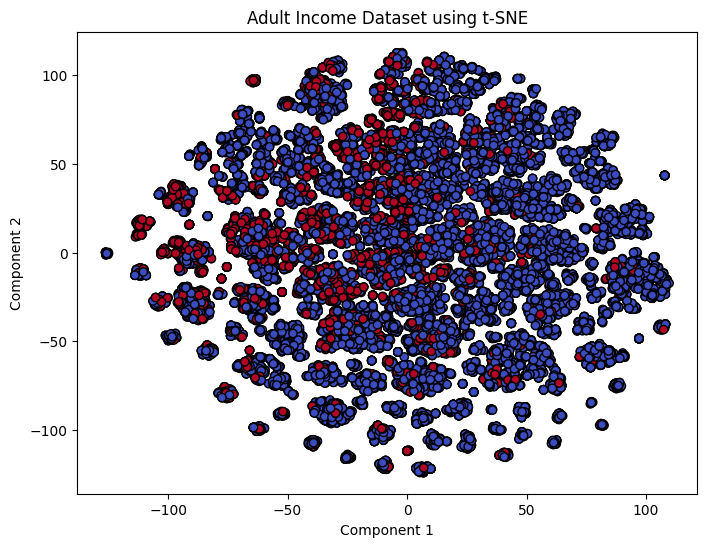

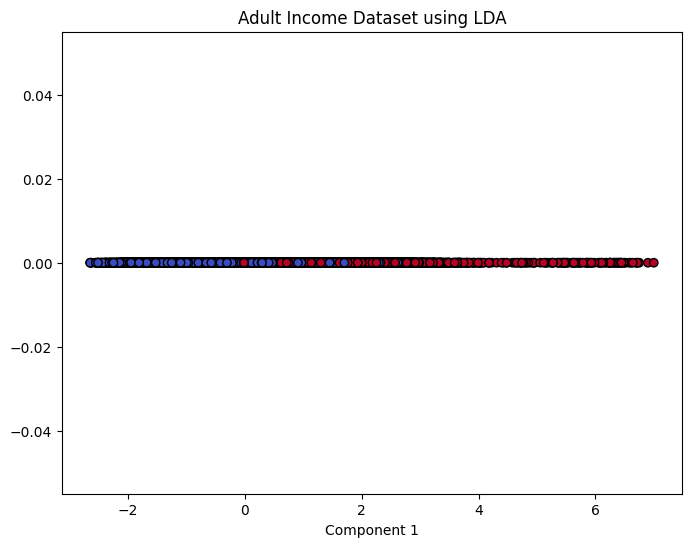

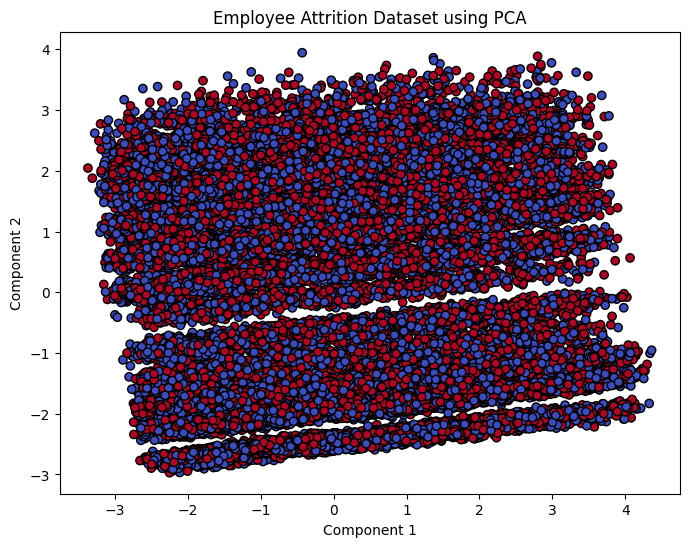

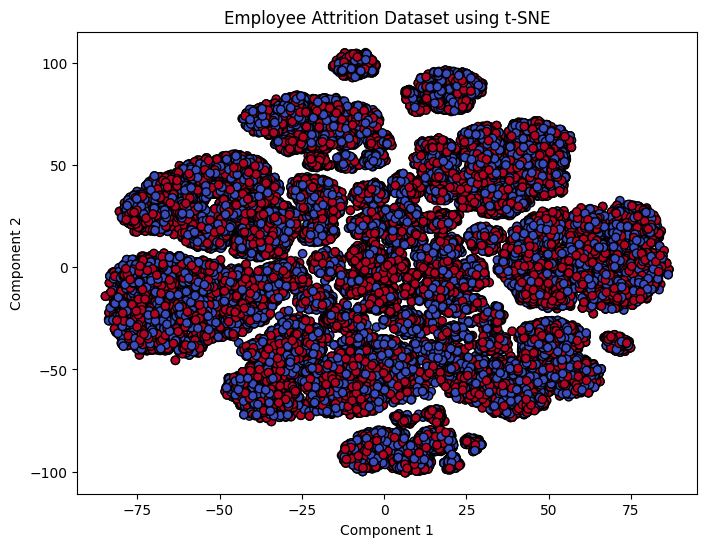

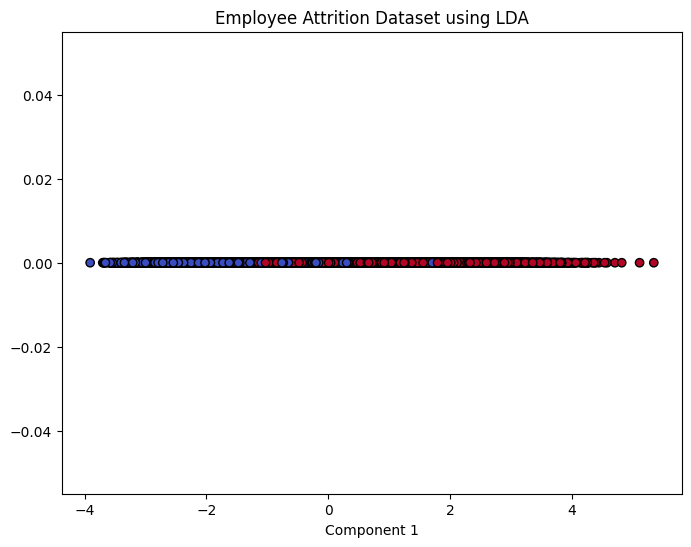

In [26]:
plot_dim_reduction(X_train_scaled_1, y_train_1, "PCA", "Adult Income Dataset")
plot_dim_reduction(X_train_scaled_1, y_train_1, "t-SNE", "Adult Income Dataset")
plot_dim_reduction(X_train_scaled_1, y_train_1, "LDA", "Adult Income Dataset")

plot_dim_reduction(X_train_scaled_2, y_train_2, "PCA", "Employee Attrition Dataset")
plot_dim_reduction(X_train_scaled_2, y_train_2, "t-SNE", "Employee Attrition Dataset")
plot_dim_reduction(X_train_scaled_2, y_train_2, "LDA", "Employee Attrition Dataset")

Adult Income Dataset

PCA:

Можно увидеть, что данные не образуют явно отделённых групп. Это потому, что в реальности факторы, влияющие на доход, часто пересекаются.

Тем не мене, облака красных и синих точек частично разделяются, слева красных точек больше чем синих — это хороший признак, что модель сможет выделить границы.

t-SNE:

Обычно t-SNE даёт более чистую картинку, чем PCA, особенно если есть нелинейные зависимости. Видно множество компактных кластеров одного цвета — признаки хорошо описывают различия.  

LDA:

Здесь можно наблюдать, насколько хорошо классы можно линейно разделить (в 1D, т. к. класификация бинарная). Как и в случае с PCA, явного разделения не наблюдается, но точки разнесены в пространстве, пусть и с широким пересечением.

Полученнные результаты нормальны, настоящие данные редко идеально предсказываются моделями, а природа целевой переменной сложна.

Employee Attrition Dataset

Необходимо помнить о том что это синтетический датасет.

PCA:

Точки двух классов разбросаны и не образуют кластеров, это нормально: текучесть — сложный социальный процесс.

t-SNE:

Сотрудники, склонные к уходу, могут формировать свои «психографические» кластеры.

Если кластеры есть — значит, твои признаки действительно «улавливают» поведение. Однако их нет

LDA:

Разделимость еще хуже чем с первым даасетом

Плохая разделимость с данным методами это не всегда плохо. Это означает, что задача не тривиальна.

Модели с нелинейными решающими границами (например, Random Forest, Gradient Boosting, SVM с ядром) всё ещё могут хорошо справиться.

Также стоит посмотреть на важность признаков и попробовать feature engineering.

Полная оценка до PCA и после PCA на одном из датасетов

In [49]:
# Модели для сравнения
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "SVM": SVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled_1)
X_test_pca = pca.transform(X_test_scaled_1)

lda = LDA()
X_train_lda = lda.fit_transform(X_train_scaled_1, y_train_1)
X_test_lda = lda.transform(X_test_scaled_1)

tsne = TSNE(n_components=2, random_state=112, n_jobs=-1)
X_train_tsne = tsne.fit_transform(X_train_scaled_1)

def evaluate_model(name, model, X_train, y_train, X_test, y_test, suffix):
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()

    acc = accuracy_score(y_test, y_pred)
    train_time = end_train - start_train
    pred_time = end_pred - start_pred

    file_name = f"{name.replace(' ', '_').lower()}_{suffix}.pkl"
    joblib.dump(model, file_name)
    size_kb = os.path.getsize(file_name) / 1024

    return {
        "Модель": name,
        "Признаки": suffix,
        "Точность": round(acc, 4),
        "Время обучения (сек)": round(train_time, 4),
        "Время предсказания (сек)": round(pred_time, 4),
        "Размер модели (KB)": round(size_kb, 2)
    }

all_results = []

for name, model in models.items():
    # Полные признаки
    res_full = evaluate_model(name, model, X_train_scaled_1, y_train_1, X_test_scaled_1, y_test_1, "full")
    all_results.append(res_full)

    # Признаки после уменьшения размерности
    try:
        model_pca = model.__class__(**model.get_params())
        res_pca = evaluate_model(name, model_pca, X_train_pca, y_train_1, X_test_pca, y_test_1, "pca")
        all_results.append(res_pca)
    except Exception as e:
        print(f"Проблема с {name} после PCA: {e}")

    try:
        model_lda = model.__class__(**model.get_params())
        res_lda = evaluate_model(name, model_lda, X_train_lda, y_train_1, X_test_lda, y_test_1, "lda")
        all_results.append(res_lda)
    except Exception as e:
        print(f"Проблема с {name} после LDA: {e}")

    try:
        model_tsne = model.__class__(**model.get_params())
        res_tsne = evaluate_model(name, model_tsne, X_train_tsne, y_train_1, X_train_tsne, y_train_1, "tsne_train_only")
        all_results.append(res_tsne)
    except Exception as e:
        print(f"Проблема с {name} после t-SNE: {e}")

df_all = pd.DataFrame(all_results)
print("\nТаблица сравнения всех моделей:")
print(df_all)


Таблица сравнения всех моделей:
                 Модель         Признаки  Точность  Время обучения (сек)  \
0   Logistic Regression             full    0.8095                0.3574   
1   Logistic Regression              pca    0.8072                0.2304   
2   Logistic Regression              lda    0.8044                0.0197   
3   Logistic Regression  tsne_train_only    0.6730                0.0367   
4                   SVM             full    0.8006               61.7730   
5                   SVM              pca    0.8002               68.0547   
6                   SVM              lda    0.7898               22.2736   
7                   SVM  tsne_train_only    0.7144               29.3475   
8         Random Forest             full    0.8506                4.7553   
9         Random Forest              pca    0.8267               52.7600   
10        Random Forest              lda    0.7846               11.3571   
11        Random Forest  tsne_train_only    0.9999     

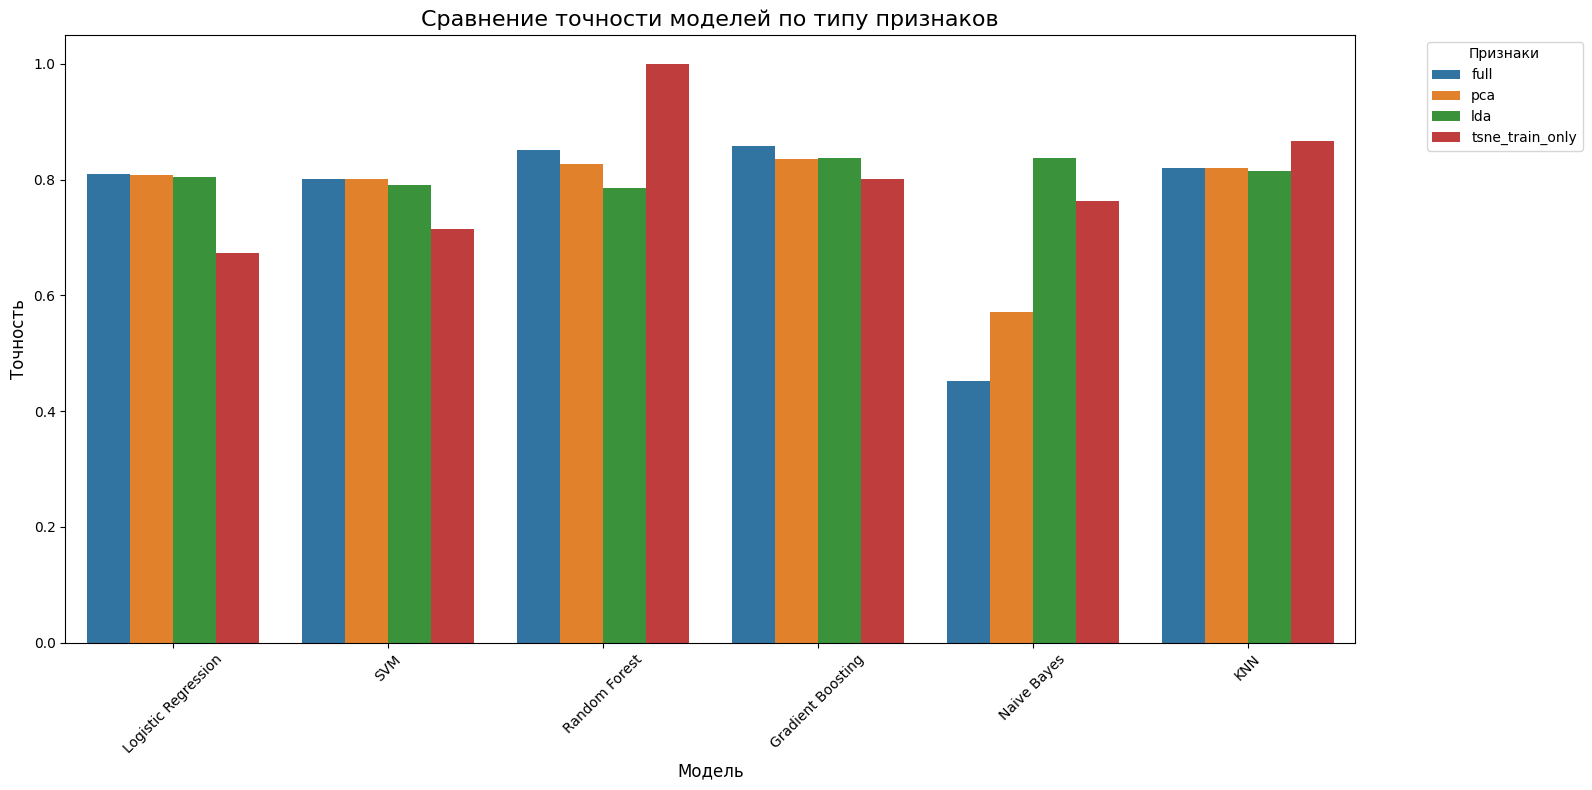

In [50]:
plt.figure(figsize=(16, 8))
sns.barplot(data=df_all, x="Модель", y="Точность", hue="Признаки")

plt.title("Сравнение точности моделей по типу признаков", fontsize=16)
plt.xlabel("Модель", fontsize=12)
plt.ylabel("Точность", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Признаки", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Gradient Boosting и Random Forest показывают наивысшую точность — около 0.85–0.86.

Naive Bayes (LDA) тоже дал необычно высокую точность (0.8366) — это ожидаемо, так как LDA хорошо сочетается с предпосылками Байеса.

t-SNE:

Сильно повлияло на модели: у Random Forest точность ~1.0, что вероятно говорит о переобучении на очень ограниченном признаковом пространстве (2D t-SNE).

Работает нестабильно, но иногда — эффективно (например, KNN и Naive Bayes).

PCA:

У большинства моделей наблюдается незначительное падение точности по сравнению с оригинальными признаками, но выигрывает по скорости и размеру модели.

Особенно хорошо работает с Naive Bayes и KNN.

LDA:

Показывает уверенные результаты на всех моделях, особенно для Naive Bayes — это логично, поскольку LDA подготавливает данные по распределению классов. Это хороший компромисс между размером модели, скоростью и точностью.

# Бутстрэппинг для оценки устойчивости моделей

In [33]:
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm

def bootstrap_evaluation(models, X, y, n_iterations=100, sample_size=3000):
    results = {name: [] for name in models}

    for i in tqdm(range(n_iterations), desc="Бутстрэппинг"):
        # Случайная бутстрэп-выборка с андерсэмплингом
        X_resampled, y_resampled = resample(
            X, y,
            replace=True,
            n_samples=min(sample_size, len(y)),  # не превышать реальный размер
            random_state=i
        )

        for name, model in models.items():
            cloned_model = model.__class__(**model.get_params())
            cloned_model.fit(X_resampled, y_resampled)
            y_pred = cloned_model.predict(X)
            acc = accuracy_score(y, y_pred)
            results[name].append(acc)

    for name, scores in results.items():
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)
        print(f"{name}: Mean Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")

    return results

In [34]:
def print_bootstrap_summary(results, dataset_name, n_iterations):
    print(f"\nРезультаты бутстрэппинга -- {dataset_name} ({n_iterations} итераций):")
    print("-" * 65)
    print(f"{'Модель':30} | {'Средняя точность':>17} | {'Ст. отклонение':>15}")
    print("-" * 65)
    for name, scores in results.items():
        mean_acc = np.mean(scores)
        std_acc = np.std(scores)
        print(f"{name:30} | {mean_acc:17.4f} | {std_acc:15.4f}")

In [35]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=5000),
    "SVM": SVC(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

print("Бутстрэппинг для Adult Income Dataset (100 итераций)")
results_income_100 = bootstrap_evaluation(models, X_train_scaled_1, y_train_1, n_iterations=100)
print_bootstrap_summary(results_income_100, "Adult Income Dataset", 100)

print("Бутстрэппинг для Adult Income Dataset (250 итераций)")
results_income_250 = bootstrap_evaluation(models, X_train_scaled_1, y_train_1, n_iterations=250)
print_bootstrap_summary(results_income_250, "Adult Income Dataset", 250)

print("Бутстрэппинг для Adult Income Dataset (500 итераций)")
results_income_500 = bootstrap_evaluation(models, X_train_scaled_1, y_train_1, n_iterations=500)
print_bootstrap_summary(results_income_500, "Adult Income Dataset", 500)


print("Бутстрэппинг для Employee Attrition Dataset (100 итераций)")
results_attrition_100 = bootstrap_evaluation(models, X_train_scaled_2, y_train_2, n_iterations=100)
print_bootstrap_summary(results_attrition_100, "Employee Attrition Dataset", 100)

print("Бутстрэппинг для Employee Attrition Dataset (250 итераций)")
results_attrition_250 = bootstrap_evaluation(models, X_train_scaled_2, y_train_2, n_iterations=250)
print_bootstrap_summary(results_attrition_250, "Employee Attrition Dataset", 250)

print("Бутстрэппинг для Employee Attrition Dataset (500 итераций)")
results_attrition_500 = bootstrap_evaluation(models, X_train_scaled_2, y_train_2, n_iterations=500)
print_bootstrap_summary(results_attrition_500, "Employee Attrition Dataset", 500)

Бутстрэппинг для Adult Income Dataset (100 итераций)


Бутстрэппинг: 100%|██████████| 100/100 [19:43<00:00, 11.84s/it]


Logistic Regression: Mean Accuracy = 0.8136, Std = 0.0042
SVM: Mean Accuracy = 0.8032, Std = 0.0065
Random Forest: Mean Accuracy = 0.8622, Std = 0.0023
Gradient Boosting: Mean Accuracy = 0.8635, Std = 0.0016
Naive Bayes: Mean Accuracy = 0.3277, Std = 0.0333
KNN: Mean Accuracy = 0.8072, Std = 0.0033

Результаты бутстрэппинга -- Adult Income Dataset (100 итераций):
-----------------------------------------------------------------
Модель                         |  Средняя точность |  Ст. отклонение
-----------------------------------------------------------------
Logistic Regression            |            0.8136 |          0.0042
SVM                            |            0.8032 |          0.0065
Random Forest                  |            0.8622 |          0.0023
Gradient Boosting              |            0.8635 |          0.0016
Naive Bayes                    |            0.3277 |          0.0333
KNN                            |            0.8072 |          0.0033
Бутстрэппинг для Ad

Бутстрэппинг: 100%|██████████| 250/250 [49:15<00:00, 11.82s/it]


Logistic Regression: Mean Accuracy = 0.8131, Std = 0.0041
SVM: Mean Accuracy = 0.8027, Std = 0.0061
Random Forest: Mean Accuracy = 0.8622, Std = 0.0019
Gradient Boosting: Mean Accuracy = 0.8636, Std = 0.0016
Naive Bayes: Mean Accuracy = 0.3268, Std = 0.0300
KNN: Mean Accuracy = 0.8073, Std = 0.0036

Результаты бутстрэппинга -- Adult Income Dataset (250 итераций):
-----------------------------------------------------------------
Модель                         |  Средняя точность |  Ст. отклонение
-----------------------------------------------------------------
Logistic Regression            |            0.8131 |          0.0041
SVM                            |            0.8027 |          0.0061
Random Forest                  |            0.8622 |          0.0019
Gradient Boosting              |            0.8636 |          0.0016
Naive Bayes                    |            0.3268 |          0.0300
KNN                            |            0.8073 |          0.0036
Бутстрэппинг для Ad

Бутстрэппинг: 100%|██████████| 500/500 [1:44:23<00:00, 12.53s/it]


Logistic Regression: Mean Accuracy = 0.8131, Std = 0.0041
SVM: Mean Accuracy = 0.8025, Std = 0.0061
Random Forest: Mean Accuracy = 0.8623, Std = 0.0021
Gradient Boosting: Mean Accuracy = 0.8636, Std = 0.0016
Naive Bayes: Mean Accuracy = 0.3285, Std = 0.0335
KNN: Mean Accuracy = 0.8071, Std = 0.0033

Результаты бутстрэппинга -- Adult Income Dataset (500 итераций):
-----------------------------------------------------------------
Модель                         |  Средняя точность |  Ст. отклонение
-----------------------------------------------------------------
Logistic Regression            |            0.8131 |          0.0041
SVM                            |            0.8025 |          0.0061
Random Forest                  |            0.8623 |          0.0021
Gradient Boosting              |            0.8636 |          0.0016
Naive Bayes                    |            0.3285 |          0.0335
KNN                            |            0.8071 |          0.0033
Бутстрэппинг для Em

Бутстрэппинг:   0%|          | 0/100 [00:15<?, ?it/s]


KeyboardInterrupt: 

Итоги бутстрэппинга Adult Income Dataset

Лучшие модели: Gradient Boosting и Random Forest показывают лучшие показатели и очень низкую дисперсию (стабильность).

Наихудший результат: Наивный Байес — очень низкая точность, возможно, не подходит для этих данных.

Логистическая регрессия и SVM: Приличные, но уступают ансамблям.

Из-за длительности процесса размер выборки сокращен до 3000 примеров. Даже в сокращенном варианте процесс оказался слишком медленным, для второго датасета анализ не был проведен

# Подбор параметров

In [36]:
# Модель со стандартными параметрами
rf_default = RandomForestClassifier(random_state=112)
rf_default.fit(X_train_scaled_2, y_train_2)

# Оценка на тесте
y_pred_default = rf_default.predict(X_test_scaled_2)
acc_default = accuracy_score(y_test_2, y_pred_default)

In [39]:
# Модель
rf = RandomForestClassifier(random_state=42)

# Сетка параметров
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 10)
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled_2, y_train_2)

# Лучшая модель
best_rf = random_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled_2)
acc_best = accuracy_score(y_test_2, y_pred_best)

print("Лучшие параметры:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Лучшие параметры: {'max_depth': 11, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 181}


In [40]:
results_table = pd.DataFrame({
    "Model": ["Random Forest (до подбора)", "Random Forest (после подбора)"],
    "Accuracy": [acc_default, acc_best]
})

print("\nСравнение точности:")
print(results_table)


Сравнение точности:
                           Model  Accuracy
0     Random Forest (до подбора)  0.749262
1  Random Forest (после подбора)  0.752550


После подбора гиперпараметров точность увеличилась с 0.7493 до 0.7526 — прирост небольшой, но статистически может быть значим, особенно на больших выборках.

Это говорит о том, что Random Forest был уже хорошо настроен по умолчанию, или выборка не особо чувствительна к изменениям параметров.

# Выводы

1. Предобработка и масштабирование данных имеют критическое значение.
На обоих датасетах (Adult Income и Employee Attrition) масштабирование данных улучшило сходимость (например, у логистической регрессии) и повысило точность моделей, особенно чувствительных к масштабам (SVM, KNN). Без масштабирования модели иногда не дают результатов, иначе говоря, просто не работают.

2. Сравнение моделей. Gradient Boosting -- лучшая точность (до 0.86), стабильность, но обучение на PCA (~180 сек). Random Forest -- высокая точность, быстро обучается, имеет большой размер модели (до 78 МБ).
Logistic Regression -- быстро, интерпретируемо.	Немного уступает по точности бустингу. Naive Bayes -- мгновенное обучение, эффективен с LDA. Очень плохой результат на исходных признаках. KNN -- хорошо работает при t-SNE, слаб без снижения размерности. Очень медленное предсказание. SVM	Высокая точность с полным набором признаков. Очень медленное обучение и предсказание

3. Снижение размерности. PCA --- ускоряет обучение, снижает размер модели. Почти не теряет точность.	Подходит для Logistic Regression, SVM
LDA -- часто улучшает точность на простых моделях (NB, KNN), t-SNE -- подходит только для визуализации или KNN.

4. Подбор гиперпараметров: эффект есть, но умеренный
Для Random Forest точность увеличилась незначительно. Это показывает, что дефолтные параметры уже хорошо работают, но тщательная настройка может дать дополнительный прирост на сложных задачах.

5. Время и размер модели. Самая тяжелая модель: Random Forest (до 78 МБ). Самая компактная и быстрая: Naive Bayes + LDA (размер < 1 КБ, обучение < 0.01 сек). SVM сильно проигрывает по скорости (до 68 сек обучения и 23 сек предсказания на t-SNE). Для систем с ограниченными ресурсами — Logistic Regression или Gradient Boosting с PCA/LDA. Для интерпретируемости — Logistic Regression + LDA. Для максимально высокой точности — Gradient Boosting без снижения размерности.